In [85]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import xgboost as xgb
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the dataset

In [84]:
train = pd.read_csv('train_v2_drcat_02.csv', sep=',')

# Tokenization and dataset split

In [3]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokens = tokenizer(train["text"].tolist(), padding=True, truncation=True, return_tensors="pt")
input_ids = tokens["input_ids"]

# XG Boost

In [76]:
y = train['label'].values
X = input_ids
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=10)
dtr = xgb.DMatrix(X_tr, label=y_tr)
dval = xgb.DMatrix(X_val)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)
params = {
    'objective': 'binary:logistic',
    'max_depth': 5,
    'learning_rate': 0.1
}

## Cross-validation for max_detph in XGBoost

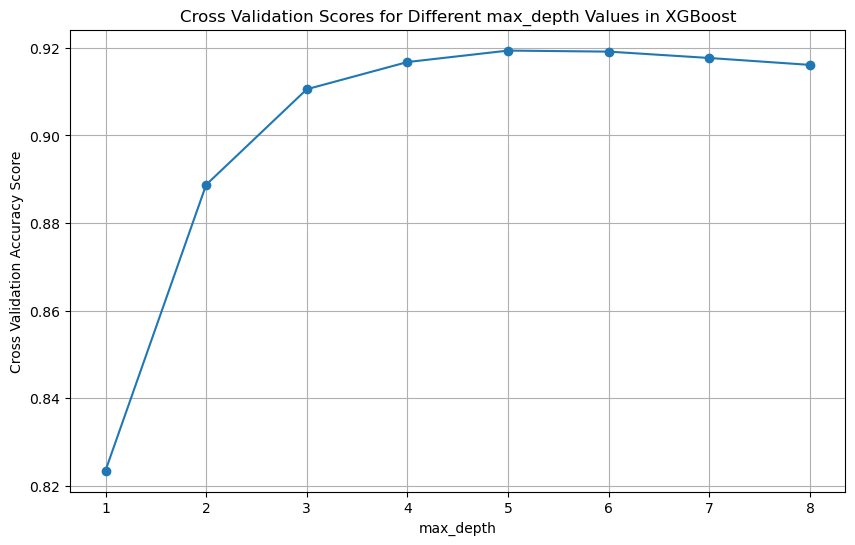

Best Max Depth: 5
Corresponding cross-validation score: 0.919378343708326


In [ ]:
max_depth_values = [1, 2, 3, 4, 5, 6, 7, 8]  # 100 values in the interval
xgb_classifier = xgb.XGBClassifier(objective = 'binary:logistic', learning_rate = 0.1, n_estimators=1000)
param_grid = {'max_depth': max_depth_values}

# Perform GridSearchCV with cross-validation (e.g., 5-fold)
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the cross-validation scores for each gamma value
cv_scores = grid_search.cv_results_['mean_test_score']

# Plotting gamma values vs. cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, cv_scores, marker='o', linestyle='-')
plt.title('Cross Validation Scores for Different max_depth Values in XGBoost')
plt.xlabel('max_depth')
plt.ylabel('Cross Validation Accuracy Score')
plt.grid(True)
plt.show()
best_max_depth = grid_search.best_params_['max_depth']
best_score = grid_search.best_score_

print(f"Best Max Depth: {best_max_depth}")
print(f"Corresponding cross-validation score: {best_score}")

## Training and Validating the model

In [77]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 5,
    'learning_rate': 0.1
}
model = xgb.train(params, dtr, num_boost_round=1000)
y_train_pred = model.predict(dtr)
train_pred_labels = [1 if pred > 0.5 else 0 for pred in y_train_pred]
train_accuracy = accuracy_score(y_tr, train_pred_labels)
y_val_pred = model.predict(dval)
val_pred_labels = [1 if pred > 0.5 else 0 for pred in y_val_pred]
val_accuracy = accuracy_score(y_val, val_pred_labels)
print(f"Training accuracy: {train_accuracy}")
print(f"Test(Validation) accuracy: {val_accuracy}")

Training accuracy: 1.0
Test(Validation) accuracy: 0.9170331629620825


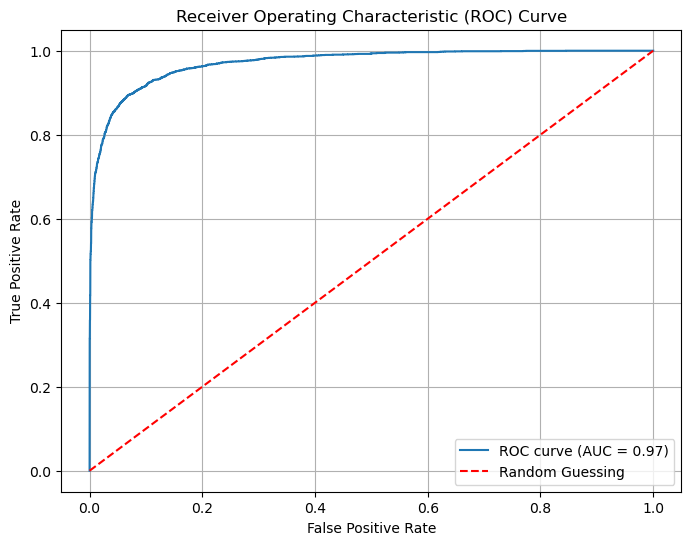

AUC:0.9716105648252216


In [75]:
#valiation ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

print(f"AUC:{roc_auc}")

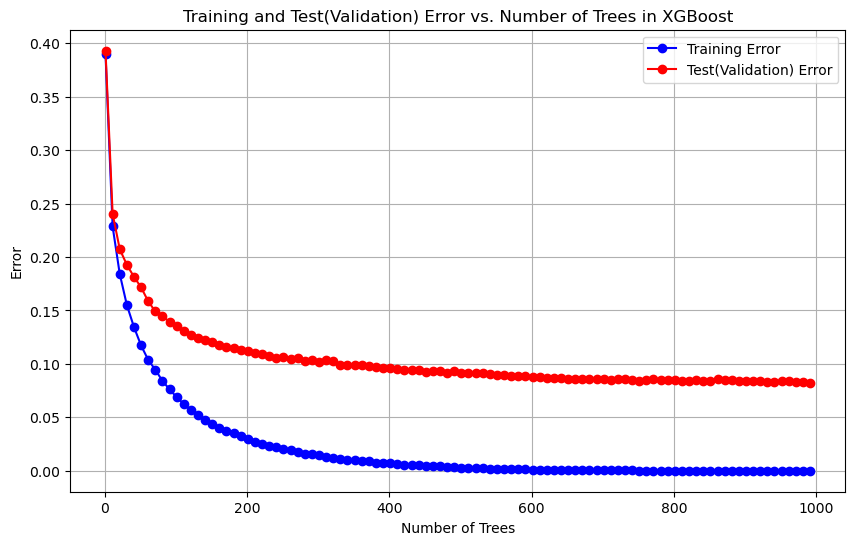

In [80]:
step = 10  # Define the step size for iterations
T = 1000
train_error_list = []
val_error_list = []
# Evaluate train and test errors for each nth boosting round
for i in range(1, T + 1, step):
    # Training error
    model = xgb.train(params, dtr, num_boost_round=i)
    y_train_pred = model.predict(dtr)
    train_pred_labels = [1 if pred > 0.5 else 0 for pred in y_train_pred]
    train_accuracy = accuracy_score(y_tr, train_pred_labels)
    train_error_list.append(1 - train_accuracy)
    
    # Validation error
    y_val_pred = model.predict(dval)
    val_pred_labels = [1 if pred > 0.5 else 0 for pred in y_val_pred]
    val_accuracy = accuracy_score(y_val, val_pred_labels)
    val_error_list.append(1 - val_accuracy)

# Plotting train and test errors vs. number of trees
plt.figure(figsize=(10, 6))
plt.plot(range(1, T + 1, step), train_error_list, marker='o', linestyle='-', color='b', label='Training Error')
plt.plot(range(1, T + 1, step), val_error_list, marker='o', linestyle='-', color='r', label='Test(Validation) Error')
plt.xlabel('Number of Trees')
plt.ylabel('Error')
plt.title(f'Training and Test(Validation) Error vs. Number of Trees in XGBoost')
plt.legend()
plt.grid(True)
plt.show()

## Test accuracy and AUC

In [78]:
#train the model on the whole training set and use it on test set
model = xgb.train(params, dtrain, num_boost_round=1000)
y_test_pred = model.predict(dtest)
test_pred_labels = [1 if pred > 0.5 else 0 for pred in y_test_pred]
test_accuracy = accuracy_score(y_test, test_pred_labels)
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.9245787643755015


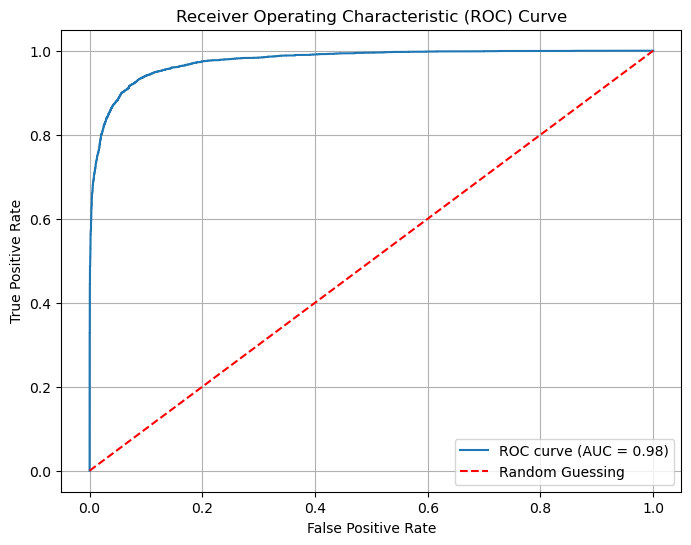

AUC:0.976716577021854


In [81]:
#test ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

print(f"AUC:{roc_auc}")

In [79]:
#number of parameters
num_trees = 1000  # or specify the number of trees
max_depth = params['max_depth']
num_parameters = num_trees * (2**(max_depth + 1) - 1)
print(f"Estimated number of parameters in the XGBoost model: {num_parameters}")

Estimated number of parameters in the XGBoost model: 63000
